<a href="https://colab.research.google.com/github/micah-shull/Data_Analysis/blob/main/DataAnalysis_3_Advanced_Modeling_Techniques_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Advanced Modeling Techniques

In the realm of machine learning, advanced modeling techniques encompass a variety of sophisticated methods designed to enhance the predictive power and robustness of models. These techniques go beyond simple algorithms, leveraging multiple models, complex structures, and optimization strategies to achieve superior performance.

### Ensemble Methods

#### What They Are
Ensemble methods combine multiple individual models to create a more robust and accurate predictive model. The idea is that by aggregating the predictions of several models, the ensemble can reduce errors and outperform any single model.

#### Types of Ensemble Methods

1. **Random Forest**:
   - **Description**: An ensemble of decision trees, where each tree is trained on a random subset of the data and features. The final prediction is made by averaging the predictions of all trees (regression) or by majority voting (classification).
   - **Strengths**: Handles large datasets and high-dimensional data well, reduces overfitting, and provides feature importance.
   - **Weaknesses**: Can be computationally intensive and less interpretable than a single decision tree.

2. **Gradient Boosting**:
   - **Description**: Builds an ensemble of trees sequentially, where each new tree corrects the errors of the previous ones. Common implementations include Gradient Boosting Machines (GBM), XGBoost, LightGBM, and CatBoost.
   - **Strengths**: High accuracy, handles various types of data, and can model complex relationships.
   - **Weaknesses**: Prone to overfitting if not properly tuned, computationally expensive, and requires careful parameter tuning.

###Data Import and Preprocessing

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the dataset
data = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = data.frame

# Identifying numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['category']).columns

# Convert 'education-num' to categorical explicitly if not already
df['education-num'] = df['education-num'].astype('category')

# Display information about the dataset
print(df.info())

# Sample the dataset to make it run faster
# dfs = df.sample(frac=0.2, random_state=42)

# Function to remove outliers using the IQR method
def remove_outliers_iqr(df):
    df_clean = df.copy()
    numerical_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns

    for col in numerical_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    return df_clean

# Remove outliers
dfs_clean = remove_outliers_iqr(dfs)

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(dfs_clean, columns=categorical_features, drop_first=True)

# Define features (X) and target (y)
X = df_encoded.drop(columns='class_>50K')
y = df_encoded['class_>50K']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  category
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(10), int64(5)
memory usage: 2.3 MB
None


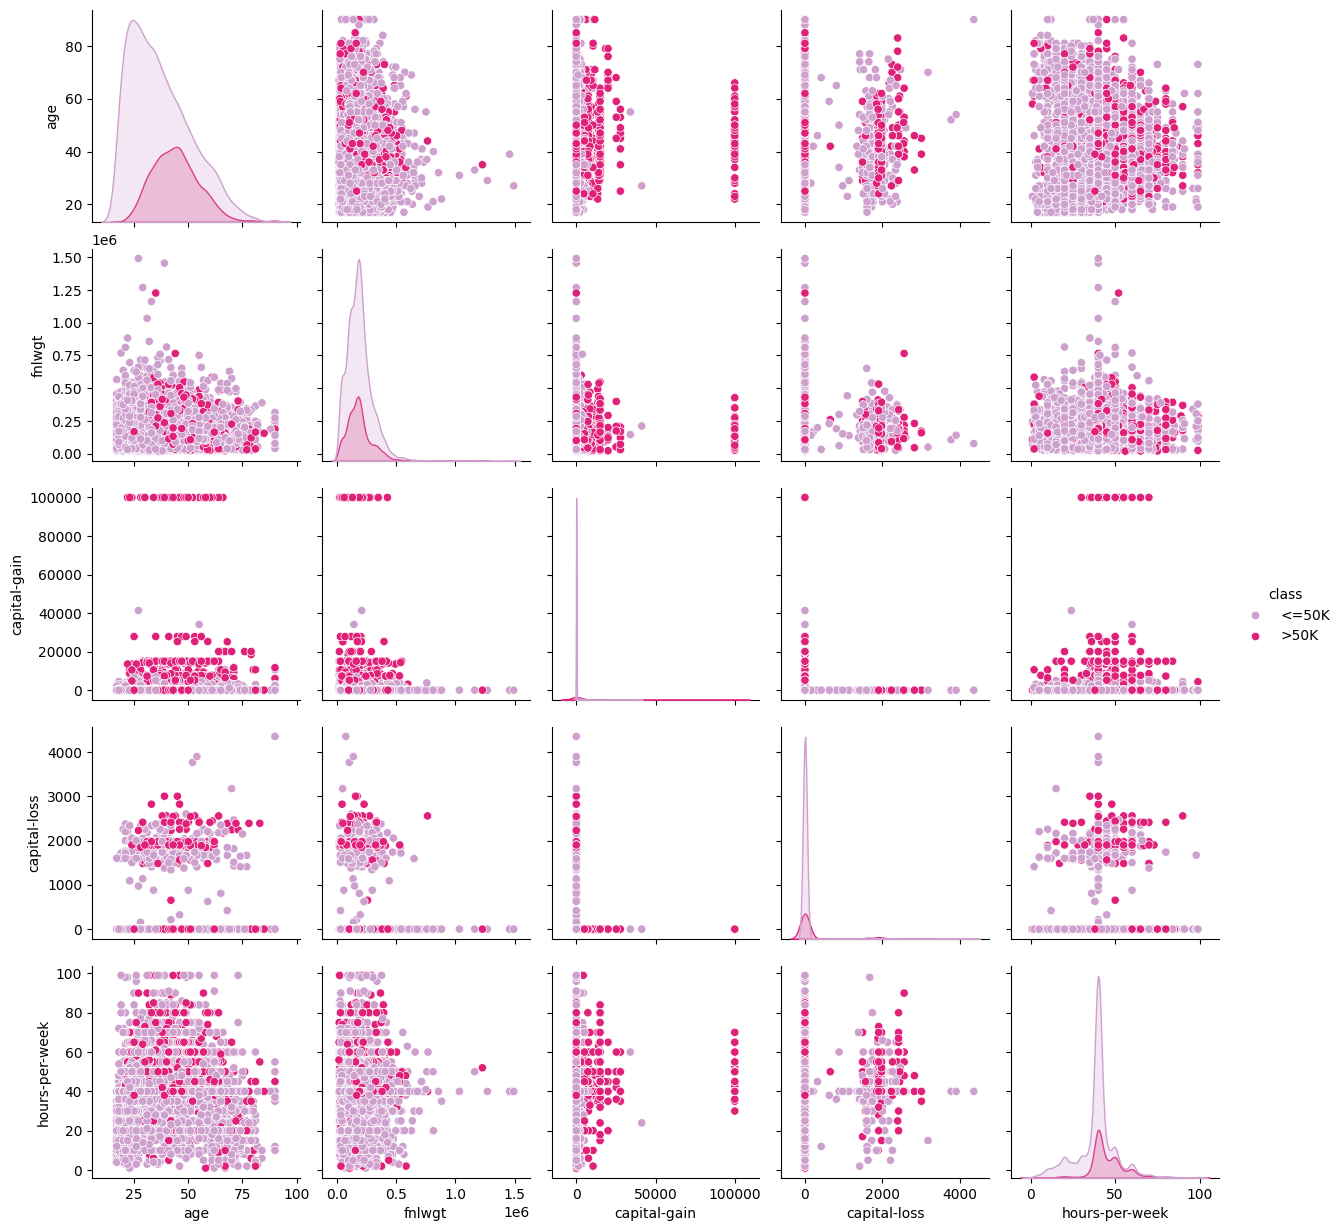

In [3]:
# Sample the dataset to make it run faster
dfs = df.sample(frac=0.2, random_state=42)
sns.pairplot(dfs, hue='class', palette='PuRd')
plt.show()

### Evaluate Models and Compare Performance

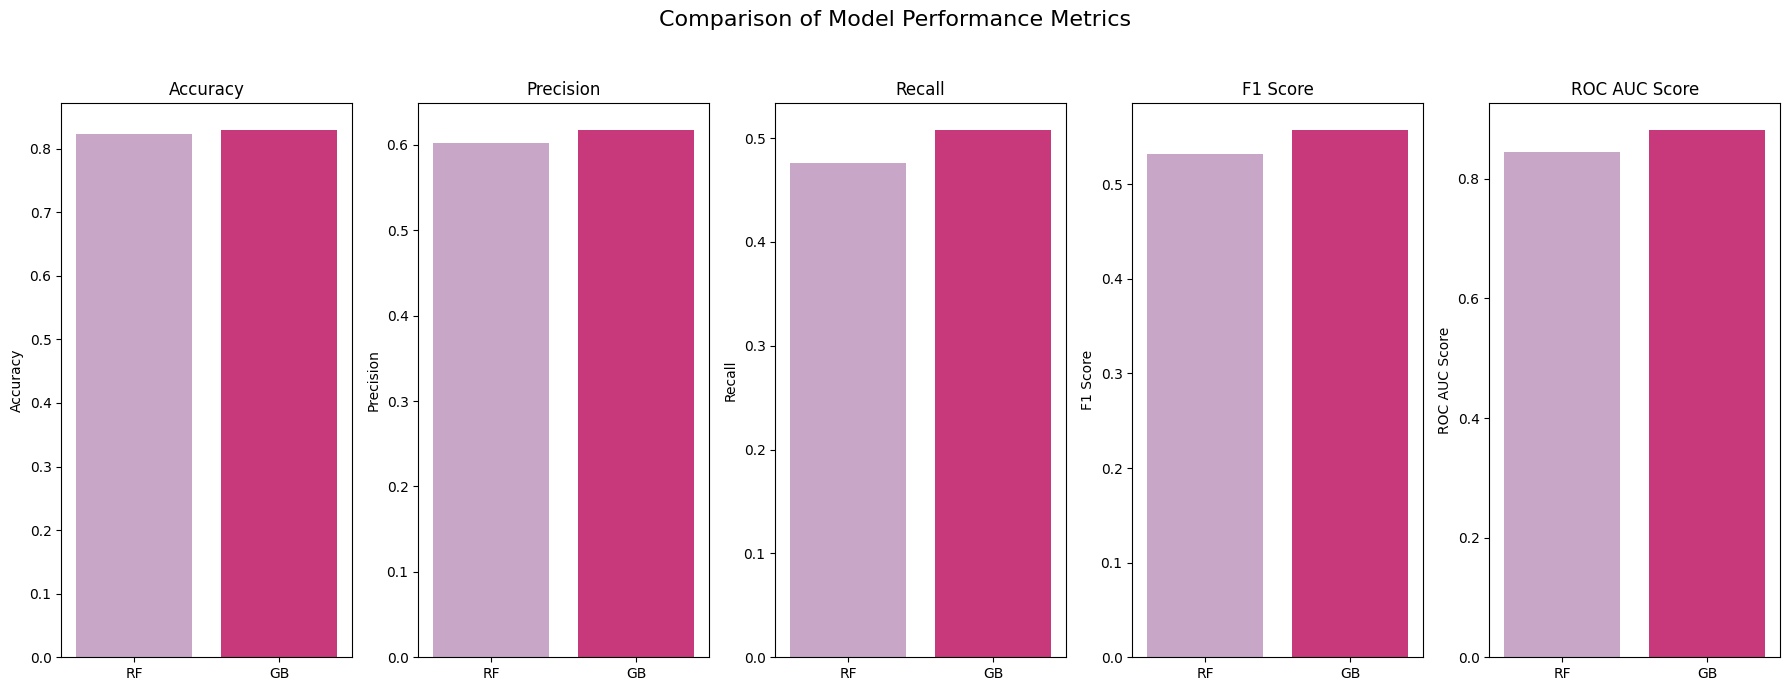

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test, abbrev):
    """
    Trains the model, makes predictions, and gathers performance metrics.

    Parameters:
    model: A machine learning model instance.
    X_train: Training features.
    X_test: Testing features.
    y_train: Training labels.
    y_test: Testing labels.
    abbrev: Abbreviation for the model name.

    Returns:
    A dictionary containing the model name, abbreviation, and performance metrics.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0] * len(y_test)

    # Calculate metrics
    metrics = {
        'Model': model.__class__.__name__,
        'Abbrev': abbrev,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC Score': roc_auc_score(y_test, y_pred_proba)
    }

    return metrics

def plot_metrics(metrics_df):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 7), sharey=False)
    fig.suptitle('Comparison of Model Performance Metrics', fontsize=16)
    for i, metric in enumerate(metrics):
        sns.barplot(x='Abbrev', y=metric, data=metrics_df, hue='Model', palette='PuRd', ax=axes[i], legend=False)
        axes[i].set_title(metric)
        axes[i].set_xlabel('')
        axes[i].set_ylabel(metric)
        # axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Initialize the models with abbreviations
models = [
    (RandomForestClassifier(random_state=42), 'RF'),
    (GradientBoostingClassifier(random_state=42), 'GB')
]

# Evaluate the models
metrics_list = [evaluate_model(model, X_train, X_test, y_train, y_test, abbrev) for model, abbrev in models]
# Collect metrics into a DataFrame
metrics_df = pd.DataFrame(metrics_list)
# Plot metrics
plot_metrics(metrics_df)

###Class Imbalance

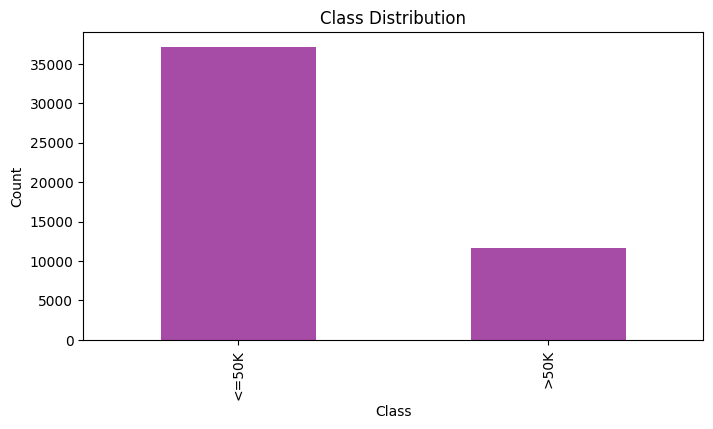

In [ ]:
df['class'].value_counts().plot(kind='bar', color='purple', alpha=0.7, figsize=(8, 4))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Handling imbalanced data is crucial because many machine learning algorithms assume an equal distribution of classes and may perform poorly when this assumption is violated. Here are some effective methods to handle imbalanced data, along with brief descriptions:

### 1. Resampling Techniques

**a. Over-Sampling**:
- **Description**: Increases the number of instances in the minority class by replicating them or generating synthetic examples.
- **Techniques**:
  - **Random Over-Sampling**: Randomly duplicates minority class examples.
  - **SMOTE (Synthetic Minority Over-sampling Technique)**: Generates synthetic examples by interpolating between existing minority class examples.
  - **ADASYN (Adaptive Synthetic Sampling)**: Similar to SMOTE, but focuses more on difficult-to-learn instances.
- **Pros**: Balances the dataset, can improve model performance.
- **Cons**: Risk of overfitting, increased computational cost.

**b. Under-Sampling**:
- **Description**: Reduces the number of instances in the majority class to balance the dataset.
- **Techniques**:
  - **Random Under-Sampling**: Randomly removes majority class examples.
  - **Tomek Links**: Removes instances that are very close to instances of the opposite class.
  - **Cluster Centroids**: Uses clustering algorithms to under-sample by replacing clusters of majority class instances with their centroids.
- **Pros**: Reduces dataset size, mitigates class imbalance.
- **Cons**: Risk of losing important information, potential underfitting.

### 2. Algorithm-Level Approaches

**a. Cost-Sensitive Learning**:
- **Description**: Modifies the learning algorithm to make it sensitive to the costs associated with misclassifying minority class instances.
- **Techniques**:
  - **Weighted Loss Function**: Assigns higher penalties to misclassifications of the minority class.
  - **Class Weights**: Adjusts class weights within the algorithm (e.g., in `RandomForestClassifier` or `SVM`).
- **Pros**: Directly integrates imbalance handling into model training, effective for various algorithms.
- **Cons**: Requires tuning of cost parameters, may increase computational complexity.

### 3. Data-Level Approaches

**a. Data Augmentation**:
- **Description**: Generates new training samples through transformations (e.g., rotating, flipping) to augment the minority class.
- **Pros**: Increases dataset diversity, improves generalization.
- **Cons**: Can be computationally expensive, not always applicable to all data types.

### 4. Ensemble Methods

**a. Balanced Ensemble Techniques**:
- **Description**: Combines multiple weak learners, each trained on balanced subsets of the data.
- **Techniques**:
  - **Balanced Random Forest**: Combines Random Forest with random under-sampling.
  - **EasyEnsemble**: Creates multiple balanced subsets of the data using under-sampling and trains an ensemble of classifiers.
- **Pros**: Combines the strengths of ensemble learning and resampling, robust to imbalance.
- **Cons**: Increased computational cost, complexity in implementation.

### 5. Anomaly Detection Methods

**a. One-Class SVM**:
- **Description**: Treats the minority class as anomalies and trains a model to distinguish between normal (majority) and anomaly (minority) instances.
- **Pros**: Effective for highly imbalanced data, suitable for anomaly detection tasks.
- **Cons**: Requires careful tuning, may not always generalize well.

### Summary

- **Over-Sampling**: Increases the minority class size (e.g., SMOTE).
- **Under-Sampling**: Reduces the majority class size.
- **Cost-Sensitive Learning**: Adjusts learning algorithms to penalize misclassifications of the minority class more heavily.
- **Data Augmentation**: Generates new training samples through transformations.
- **Balanced Ensemble Techniques**: Combines ensemble learning with resampling.
- **Anomaly Detection**: Treats the minority class as anomalies.

Each method has its pros and cons, and the choice of technique depends on the specific dataset and problem at hand. Combining multiple techniques often yields the best results.

#### Resampling with Smote

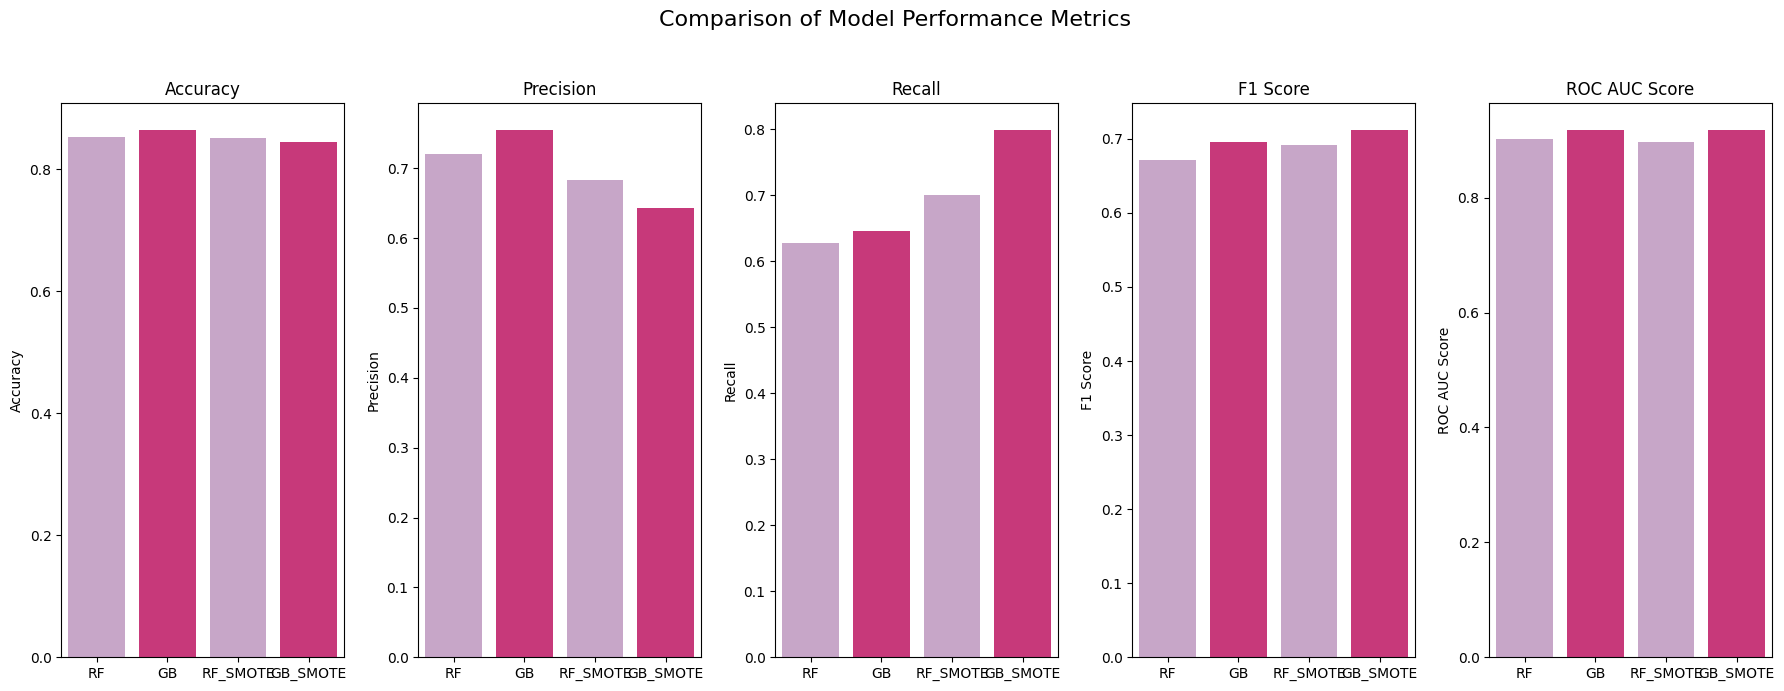

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load the dataset
data = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = data.frame

# Identifying numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['category']).columns
# Convert 'education-num' to categorical explicitly if not already
df['education-num'] = df['education-num'].astype('category')

# Sample the dataset to make it run faster
dfs = df.sample(frac=0.1, random_state=42)

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(dfs, columns=categorical_features, drop_first=True)

# Define features (X) and target (y)
X = df_encoded.drop(columns='class_>50K')
y = df_encoded['class_>50K']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Apply SMOTE to handle class imbalance on the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the models with abbreviations
models = [
    (RandomForestClassifier(random_state=42), 'RF'),
    (GradientBoostingClassifier(random_state=42), 'GB')
]

# Evaluate the models without SMOTE
metrics_list_no_smote = [evaluate_model(model, X_train, X_test, y_train, y_test, f'{abbrev}') for model, abbrev in models]

# Evaluate the models with SMOTE
metrics_list_smote = [evaluate_model(model, X_train_res, X_test, y_train_res, y_test, f'{abbrev}_SMOTE') for model, abbrev in models]

# Combine metrics into a DataFrame
metrics_df_smote = pd.DataFrame(metrics_list_no_smote + metrics_list_smote)

# Plot the performance metrics
plot_metrics(metrics_df_smote)


### Hyperparameter Tuning

#### What It Is
Hyperparameter tuning involves optimizing the parameters of a model that are not learned from the data but set prior to training. Proper tuning can significantly improve model performance.

#### Methods

1. **Grid Search**:
   - **Description**: Exhaustively searches through a specified parameter grid, evaluating every combination of parameters.
   - **Strengths**: Guarantees finding the best combination within the grid.
   - **Weaknesses**: Computationally expensive, especially with large grids and complex models.

2. **Random Search**:
   - **Description**: Randomly samples from the parameter grid and evaluates a specified number of combinations.
   - **Strengths**: More efficient than grid search, often finds good hyperparameters with fewer evaluations.
   - **Weaknesses**: May miss the optimal combination, requires setting the number of iterations.

####Grid Search

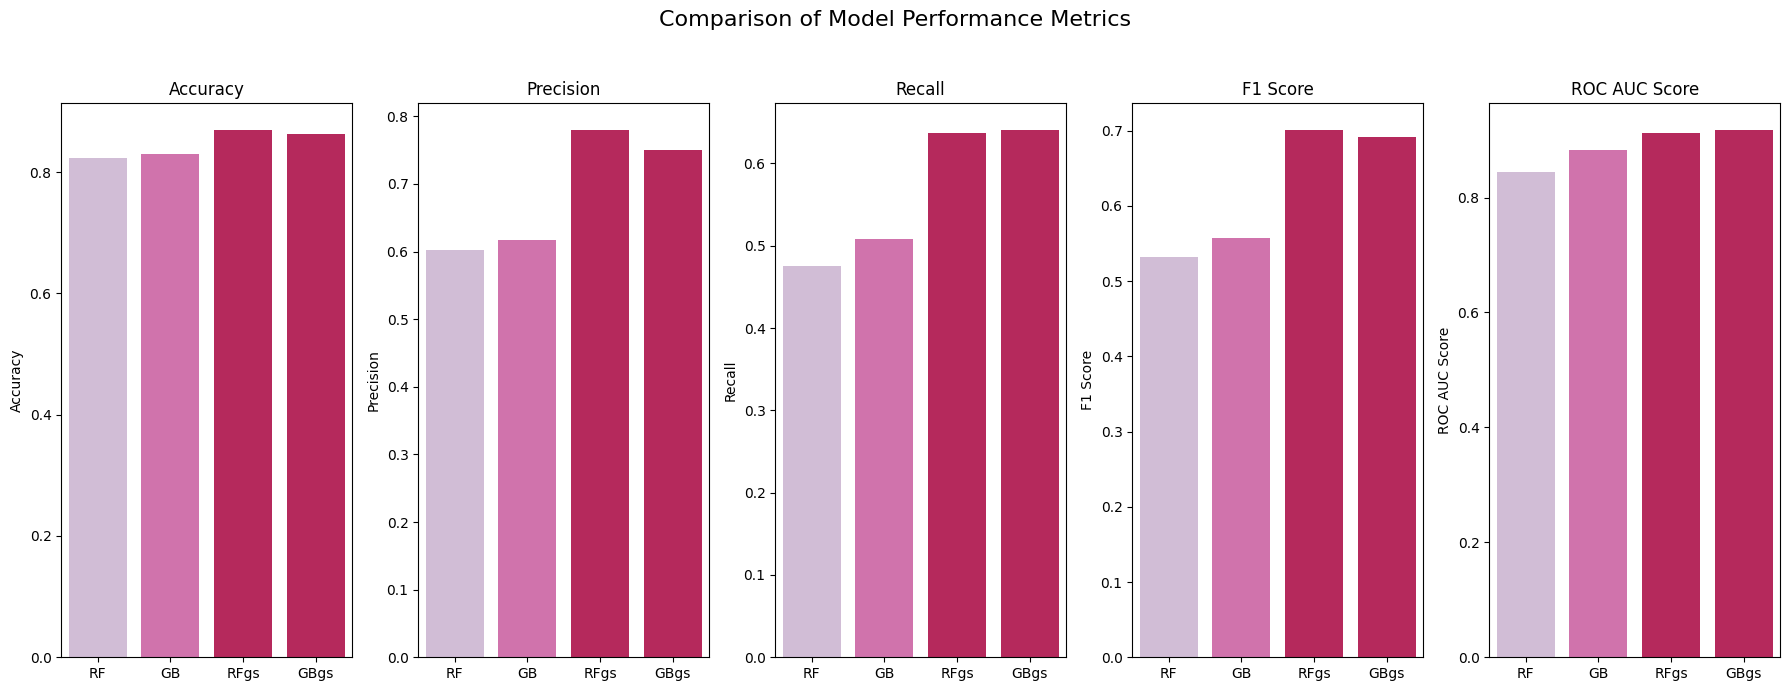

In [16]:
# Define parameter grids for tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV for both models
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Perform GridSearchCV and evaluate the tuned models
rf_tuned_metrics = evaluate_model(rf_grid_search, X_train, X_test, y_train, y_test, 'RFgs')
gb_tuned_metrics = evaluate_model(gb_grid_search, X_train, X_test, y_train, y_test, 'GBgs')

# Collect metrics into a DataFrame for tuned models
metrics_gs_tuned_df = pd.DataFrame([rf_tuned_metrics, gb_tuned_metrics])

# Combine original and tuned metrics into one DataFrame
combined_gridsearch_metrics_df = pd.concat([metrics_df, metrics_gs_tuned_df], ignore_index=True)

# Plot the performance metrics
plot_metrics(combined_gridsearch_metrics_df)


In [18]:
combined_gridsearch_metrics_df

,Model,Abbrev,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,RF,0.822828,0.602041,0.475806,0.531532,0.844815
1,GradientBoostingClassifier,GB,0.829642,0.617647,0.508065,0.557522,0.882089
2,GridSearchCV,RFgs,0.870010,0.780105,0.636752,0.701176,0.912362
3,GridSearchCV,GBgs,0.862845,0.750000,0.641026,0.691244,0.917975


####Random Search

####What is Random Search?

Random Search is a hyperparameter optimization technique used to find the best hyperparameters for a machine learning model. Unlike Grid Search, which exhaustively searches through a specified parameter grid, Random Search samples a fixed number of hyperparameter combinations from a given distribution or set of possible values.

#### How Does Random Search Work?

1. **Parameter Distributions**: Define a distribution of possible values for each hyperparameter.
2. **Random Sampling**: Randomly sample a fixed number of combinations from these distributions.
3. **Model Evaluation**: For each sampled combination, train the model and evaluate its performance using cross-validation.
4. **Best Combination**: Select the combination that yields the best performance according to the chosen evaluation metric.

#### Differences Between Random Search and Grid Search

1. **Exhaustiveness**:
   - **Grid Search**: Evaluates all possible combinations within a predefined grid. It ensures that the global optimum within the grid is found but can be computationally expensive, especially with a large number of hyperparameters and possible values.
   - **Random Search**: Randomly samples combinations, which means it does not guarantee finding the global optimum but is more efficient as it explores the parameter space more broadly with fewer evaluations.

2. **Efficiency**:
   - **Grid Search**: Inefficient for large hyperparameter spaces as it requires evaluating all combinations, leading to exponential growth in computational cost.
   - **Random Search**: More efficient, especially for high-dimensional spaces, because it requires fewer evaluations while still effectively exploring the parameter space.

3. **Performance**:
   - **Grid Search**: May miss the best region of hyperparameters if the grid is not fine enough.
   - **Random Search**: Has a higher probability of finding a good combination of hyperparameters as it samples more diverse combinations.

#### Why is Random Search Important?

1. **Efficiency**: Random Search is computationally more efficient than Grid Search, allowing it to explore the hyperparameter space more broadly with fewer resources.
2. **Scalability**: Suitable for high-dimensional hyperparameter spaces where Grid Search becomes impractical.
3. **Flexibility**: Can easily incorporate different types of distributions for hyperparameters, providing more flexibility in the search process.
4. **Practicality**: Often finds good hyperparameter combinations in less time, making it a practical choice for tuning models in real-world scenarios where computational resources are limited.

### Summary

Random Search is a powerful and efficient method for hyperparameter optimization that offers several advantages over Grid Search, especially in large and high-dimensional parameter spaces. It allows for a broader exploration of hyperparameters with fewer evaluations, making it a practical choice for tuning complex machine learning models.

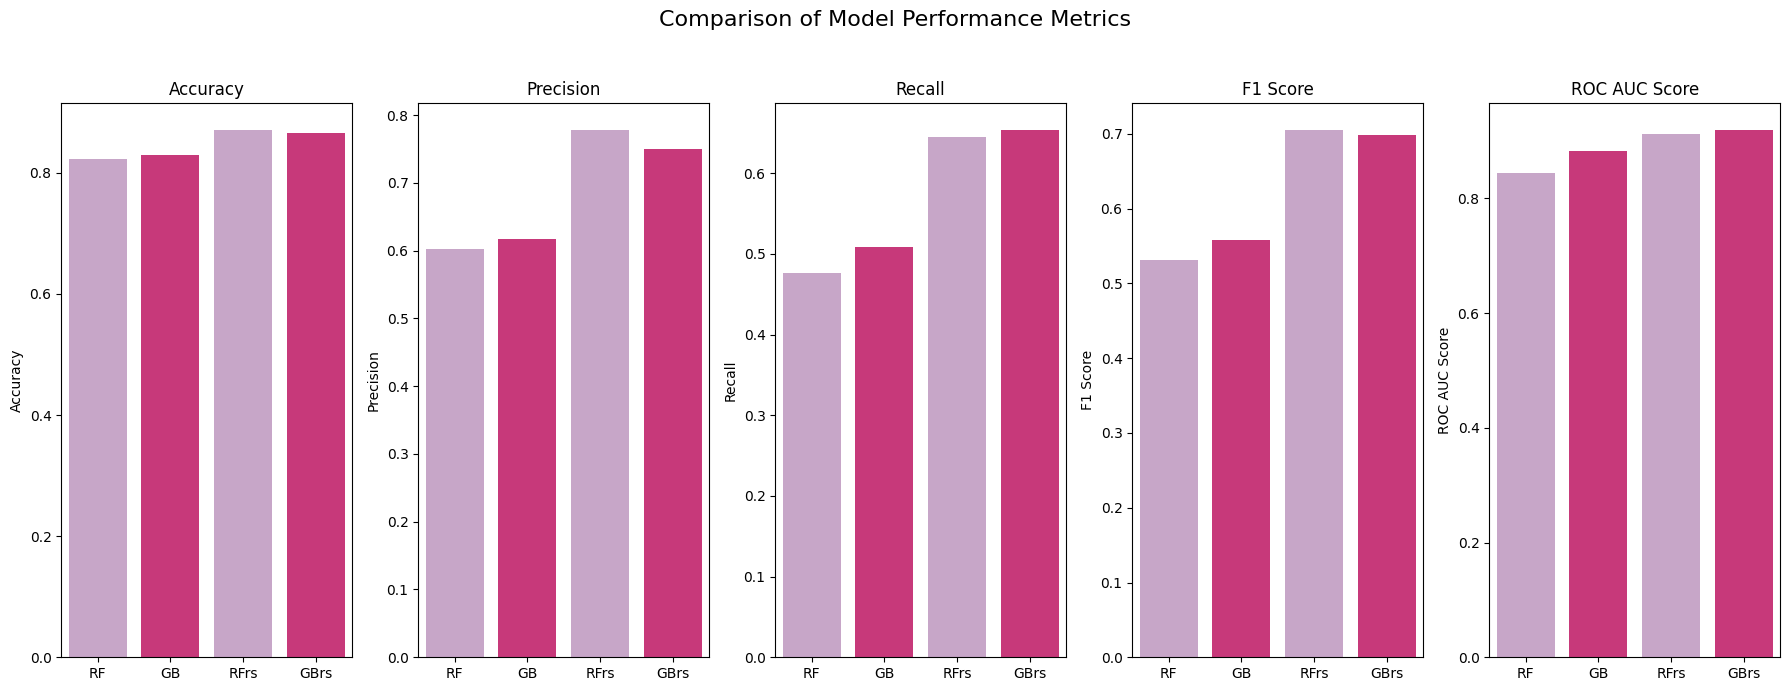

In [19]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grids for tuning
rf_param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV for both models
rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_dist, n_iter=20, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
gb_random_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), gb_param_dist, n_iter=20, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

# Perform RandomizedSearchCV and evaluate the tuned models
rf_random_search.fit(X_train, y_train)
gb_random_search.fit(X_train, y_train)

# Get the best models from random search
best_rf_model = rf_random_search.best_estimator_
best_gb_model = gb_random_search.best_estimator_

# Evaluate the tuned models
rf_tuned_metrics = evaluate_model(best_rf_model, X_train, X_test, y_train, y_test, 'RFrs')
gb_tuned_metrics = evaluate_model(best_gb_model, X_train, X_test, y_train, y_test, 'GBrs')

# Collect metrics into a DataFrame for tuned models
metrics_rs_tuned_df = pd.DataFrame([rf_tuned_metrics, gb_tuned_metrics])

# Combine original and tuned metrics into one DataFrame
combined_randsearch_metrics_df = pd.concat([metrics_df, metrics_rs_tuned_df], ignore_index=True)

# Plot the performance metrics
plot_metrics(combined_randsearch_metrics_df)


In [20]:
combined_randsearch_metrics_df

,Model,Abbrev,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,RF,0.822828,0.602041,0.475806,0.531532,0.844815
1,GradientBoostingClassifier,GB,0.829642,0.617647,0.508065,0.557522,0.882089
2,RandomForestClassifier,RFrs,0.871034,0.778351,0.645299,0.705607,0.912108
3,GradientBoostingClassifier,GBrs,0.864893,0.750000,0.653846,0.698630,0.919571


### Model Stacking and Blending

#### What They Are
Model stacking and blending are advanced ensemble techniques that combine multiple models to leverage their strengths and mitigate their weaknesses.

1. **Stacking**:
   - **Description**: Trains multiple base models and uses their predictions as input features for a higher-level meta-model, which makes the final prediction.
   - **Strengths**: Can significantly improve predictive performance by capturing different patterns from base models.
   - **Weaknesses**: Complex to implement, risk of overfitting if not properly validated.

2. **Blending**:
   - **Description**: Similar to stacking but typically simpler, blending combines the predictions of multiple models using a weighted average or other simple methods.
   - **Strengths**: Easier to implement than stacking, reduces overfitting.
   - **Weaknesses**: Generally less powerful than stacking, requires careful selection of blending weights.

### Strengths and Weaknesses of Advanced Techniques

#### Strengths
- **Improved Accuracy**: Combining multiple models often results in better performance than individual models.
- **Robustness**: Reduces the risk of overfitting by averaging out biases and variances of individual models.
- **Flexibility**: Can be applied to various types of data and tasks, including classification and regression.

#### Weaknesses
- **Complexity**: More complex to implement and interpret compared to simple models.
- **Computational Cost**: Requires more computational resources and time for training and tuning.
- **Risk of Overfitting**: Without proper validation and tuning, advanced models can overfit the training data, leading to poor generalization.

### Conclusion

Advanced modeling techniques offer powerful tools to improve the performance and robustness of machine learning models. By leveraging ensemble methods, hyperparameter tuning, and model stacking and blending, data scientists can achieve superior predictive accuracy and build models that generalize well to new data. However, these techniques come with increased complexity and computational cost, requiring careful implementation and validation to realize their full potential.

[LightGBM] [Info] Number of positive: 7486, number of negative: 23772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239491 -> initscore=-1.155474
[LightGBM] [Info] Start training from score -1.155474
[LightGBM] [Info] Number of positive: 7481, number of negative: 23777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 31258, number of used features: 85
[LightGBM] [Info] [bin

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


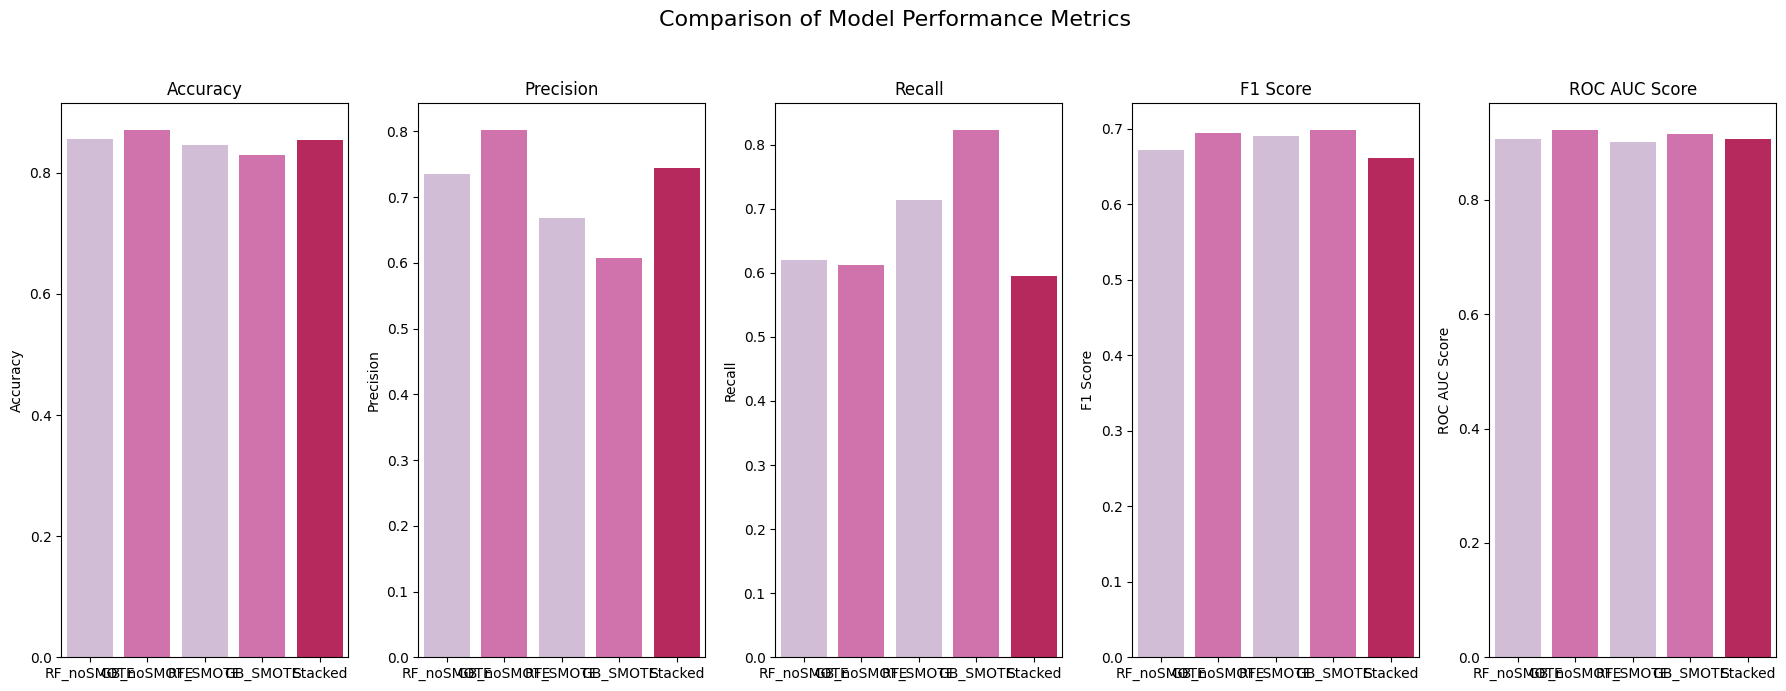

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import clone
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

# Load the dataset
data = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = data.frame
# Sample the dataset to make it run faster
dfs = df.sample(frac=0.1, random_state=42)

# Encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Define features (X) and target (y)
X = df_encoded.drop(columns='class_>50K')
y = df_encoded['class_>50K']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the numerical features
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Apply SMOTE to handle class imbalance on the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Base models for stacking
base_models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    xgb.XGBClassifier(n_estimators=100, random_state=42),
    lgb.LGBMClassifier(n_estimators=100, random_state=42)
]

# Meta-model for stacking
meta_model = LogisticRegression(random_state=42)

# Stacking function
def stacking(base_models, meta_model, X_train, y_train, X_test, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Convert data to numpy arrays
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values

    # Train base models
    S_train = np.zeros((X_train.shape[0], len(base_models)))
    S_test = np.zeros((X_test.shape[0], len(base_models)))

    for i, model in enumerate(base_models):
        S_test_i = np.zeros((X_test.shape[0], n_folds))
        for j, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
            X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
            X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]

            model_clone = clone(model)
            model_clone.fit(X_fold_train, y_fold_train)
            S_train[valid_idx, i] = model_clone.predict_proba(X_fold_valid)[:, 1]
            S_test_i[:, j] = model_clone.predict_proba(X_test)[:, 1]

        S_test[:, i] = S_test_i.mean(axis=1)

    # Train meta-model
    meta_model.fit(S_train, y_train)
    y_pred = meta_model.predict(S_test)

    return y_pred

# Apply stacking
y_pred_stack = stacking(base_models, meta_model, X_train, y_train, X_test)

# Evaluate stacked model
stacked_metrics = evaluate_model(meta_model, X_train, X_test, y_train, y_test, 'Stacked')

# Evaluate the models without SMOTE
models = [
    (RandomForestClassifier(random_state=42), 'RF_noSMOTE'),
    (GradientBoostingClassifier(random_state=42), 'GB_noSMOTE')
]
metrics_list_no_smote = [evaluate_model(model, X_train, X_test, y_train, y_test, abbrev) for model, abbrev in models]

# Evaluate the models with SMOTE
models_smote = [
    (RandomForestClassifier(random_state=42), 'RF_SMOTE'),
    (GradientBoostingClassifier(random_state=42), 'GB_SMOTE')
]
metrics_list_smote = [evaluate_model(model, X_train_res, X_test, y_train_res, y_test, abbrev) for model, abbrev in models_smote]

# Collect metrics into a DataFrame
metrics_stack_model_df = pd.DataFrame(metrics_list_no_smote + metrics_list_smote + [stacked_metrics])

# Plot the performance metrics
plot_metrics(metrics_stack_model_df)


In [22]:
metrics_stack_model_df

,Model,Abbrev,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,RF_noSMOTE,0.855564,0.735399,0.619333,0.672394,0.905499
1,GradientBoostingClassifier,GB_noSMOTE,0.871225,0.802352,0.612917,0.694956,0.922554
2,RandomForestClassifier,RF_SMOTE,0.846555,0.668002,0.713430,0.689969,0.900772
3,GradientBoostingClassifier,GB_SMOTE,0.830075,0.606873,0.823353,0.698730,0.915582
4,LogisticRegression,Stacked,0.854130,0.744248,0.594953,0.661279,0.905527


In [23]:
pd.concat([metrics_df,
           combined_gridsearch_metrics_df,
           combined_randsearch_metrics_df,
           metrics_stack_model_df], ignore_index=True)

,Model,Abbrev,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,RandomForestClassifier,RF,0.822828,0.602041,0.475806,0.531532,0.844815
1,GradientBoostingClassifier,GB,0.829642,0.617647,0.508065,0.557522,0.882089
2,RandomForestClassifier,RF,0.822828,0.602041,0.475806,0.531532,0.844815
3,GradientBoostingClassifier,GB,0.829642,0.617647,0.508065,0.557522,0.882089
4,GridSearchCV,RFgs,0.870010,0.780105,0.636752,0.701176,0.912362
5,GridSearchCV,GBgs,0.862845,0.750000,0.641026,0.691244,0.917975
6,RandomForestClassifier,RF,0.822828,0.602041,0.475806,0.531532,0.844815
7,GradientBoostingClassifier,GB,0.829642,0.617647,0.508065,0.557522,0.882089
8,RandomForestClassifier,RFrs,0.871034,0.778351,0.645299,0.705607,0.912108
9,GradientBoostingClassifier,GBrs,0.864893,0.750000,0.653846,0.698630,0.919571


### Interpretation and Explanation of Model Performance

1. **Individual Models (RF, GB)**:
   - The basic Random Forest and Gradient Boosting models without any tuning or resampling performed similarly, with Gradient Boosting showing slightly better metrics, particularly in ROC AUC Score (0.882089 vs. 0.844815).

2. **Hyperparameter Tuning (RFgs, GBgs, RFrs, GBrs)**:
   - Both Grid Search and Random Search for hyperparameter tuning significantly improved the performance of both models. For instance, RFgs improved accuracy from 0.822828 to 0.870010, and ROC AUC from 0.844815 to 0.912362.
   - Random Search (RFrs, GBrs) performed marginally better than Grid Search, indicating effective exploration of the hyperparameter space.

3. **With and Without SMOTE (RF_noSMOTE, GB_noSMOTE, RF_SMOTE, GB_SMOTE)**:
   - Applying SMOTE improved Recall and F1 Score significantly, especially for Gradient Boosting (Recall from 0.508065 to 0.823353, F1 Score from 0.557522 to 0.698730).
   - However, SMOTE slightly reduced the precision and accuracy, indicating a trade-off between handling class imbalance and overall predictive accuracy.

4. **Stacking (Stacked)**:
   - The stacked model showed balanced performance across all metrics, with a high ROC AUC Score of 0.905527.
   - Stacking effectively leveraged the strengths of multiple base models, resulting in a robust overall performance.

### Explanation of Differences

1. **Hyperparameter Tuning**:
   - Hyperparameter tuning through Grid Search and Random Search significantly improved model performance by finding the optimal set of parameters. This led to better model generalization and higher predictive power.

2. **SMOTE Resampling**:
   - SMOTE improved recall and F1 Score by balancing the classes in the training data, ensuring the model pays adequate attention to minority class instances.
   - The trade-off is a slight decrease in precision and accuracy, as SMOTE introduces synthetic examples that may increase overlap between classes.

3. **Model Stacking**:
   - Stacking combines multiple base models to leverage their individual strengths, leading to a balanced improvement across different metrics.
   - The stacked model managed to achieve high precision and ROC AUC, indicating effective aggregation of base model predictions.

### Next Steps for Improving Model Performance

1. **Advanced Hyperparameter Tuning**:
   - Consider Bayesian optimization or other advanced hyperparameter tuning techniques to further explore the hyperparameter space efficiently.

2. **Feature Engineering**:
   - Explore additional feature engineering techniques to create more informative features that capture underlying patterns in the data.

3. **Ensemble Techniques**:
   - Experiment with other ensemble methods such as AdaBoost, CatBoost, and BaggingClassifier to compare their performance.

4. **Model Interpretation**:
   - Use SHAP and LIME for model interpretation to understand feature importance and model decisions, guiding further improvements.

5. **Data Augmentation**:
   - Explore data augmentation techniques to generate more diverse training samples, particularly for the minority class.

6. **Deployment and Monitoring**:
   - Deploy the best-performing model and implement monitoring to track performance over time, ensuring the model remains accurate and relevant.

By following these steps, you can continue to enhance the performance and robustness of your predictive models, leading to more accurate and reliable results.

### Next Steps

To further enhance model performance and robustness, consider the following steps:

1. **Hyperparameter Tuning**:
   - **Comprehensive Tuning**: Conduct a detailed hyperparameter search using Grid Search or Random Search for all models, including those used in the stacking ensemble.
   - **Cross-Validation**: Ensure robustness and generalizability of the selected hyperparameters through cross-validation techniques.

2. **Feature Engineering**:
   - **Create New Features**: Explore advanced feature engineering to create more informative and relevant features that capture underlying data patterns.
   - **Domain Knowledge**: Utilize domain-specific insights to derive new features that could potentially improve model performance.

3. **Advanced Ensemble Techniques**:
   - **Experiment with Other Techniques**: Try other ensemble methods like AdaBoost, CatBoost, or BaggingClassifier to see if they offer performance gains.
   - **Model Blending**: Investigate blending techniques that combine predictions from multiple models through averaging or weighted approaches.

4. **Model Interpretation**:
   - **Understand Predictions**: Use tools like SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to interpret model predictions and feature importance.
   - **Insight-Driven Improvements**: Use these insights to refine and improve model performance further.

5. **Data Augmentation**:
   - **Enhance Training Data**: Explore data augmentation techniques to generate additional training samples, particularly for the minority class.
   - **Synthetic Data Generation**: Use synthetic data generation strategies to bolster model training and performance.

6. **Deployment and Monitoring**:
   - **Real-World Application**: Once a satisfactory model is achieved, consider deploying it in a production environment.
   - **Continuous Monitoring**: Implement monitoring to track model performance over time and retrain as necessary to maintain accuracy and relevance.

By implementing these next steps, you can continue to refine and improve your models, ensuring they deliver accurate, reliable, and robust predictions in real-world applications.

[LightGBM] [Info] Number of positive: 765, number of negative: 2360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 3125, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.244800 -> initscore=-1.126541
[LightGBM] [Info] Start training from score -1.126541
[LightGBM] [Info] Number of positive: 746, number of negative: 2379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 3125, number of used features: 52
[LightGBM] [Info] [binary:Bo

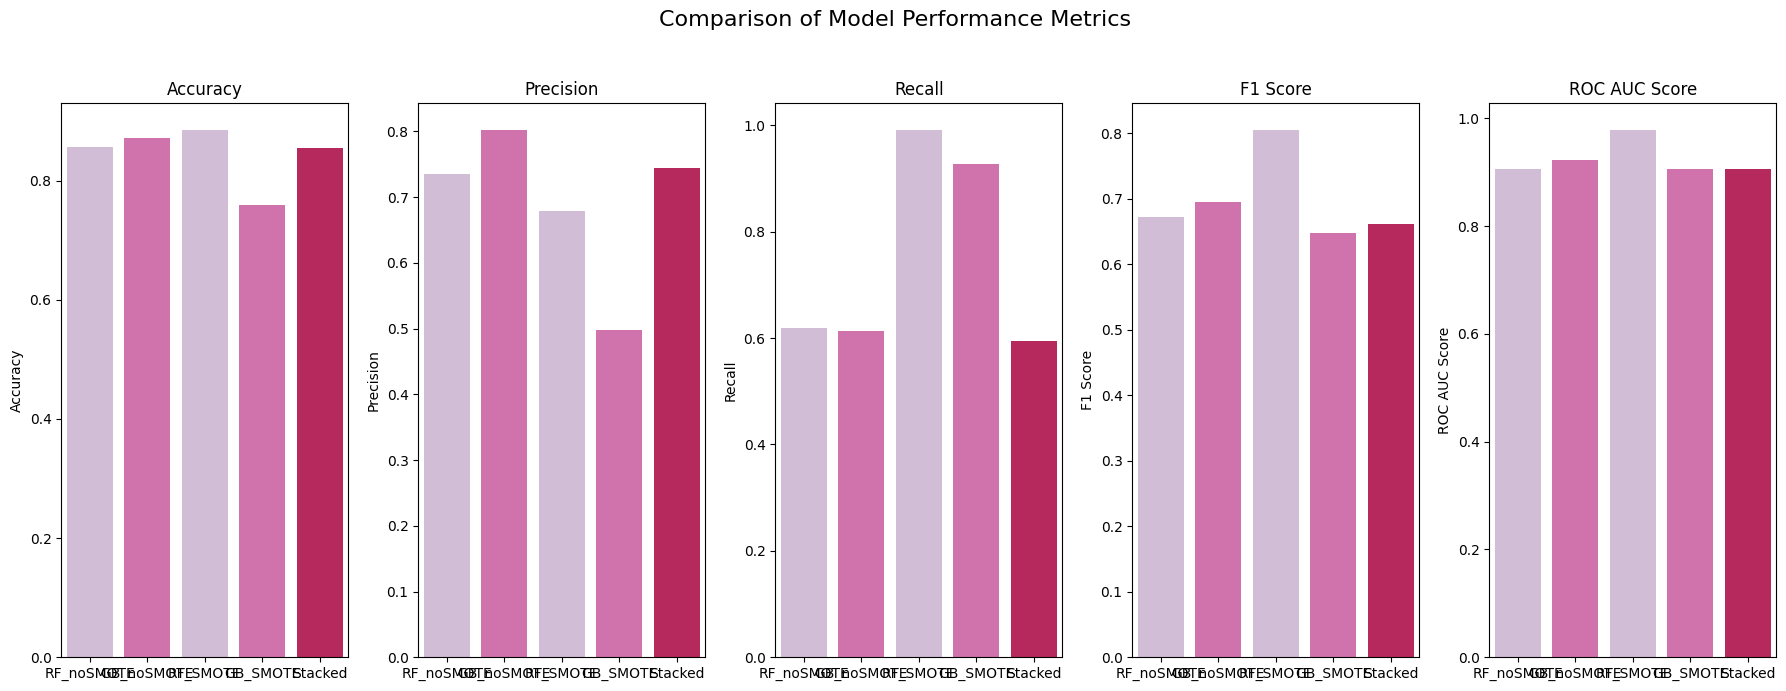

In [24]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import clone
import xgboost as xgb
import lightgbm as lgb

# Load the dataset
data = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = data.frame
# Sample the dataset to make it run faster
dfs = df.sample(frac=0.1, random_state=42)

# Encode categorical variables
df_encoded = pd.get_dummies(dfs, drop_first=True)

# Define features (X) and target (y)
X = df_encoded.drop(columns='class_>50K')
y = df_encoded['class_>50K']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the numerical features
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Base models for stacking
base_models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    xgb.XGBClassifier(n_estimators=100, random_state=42),
    lgb.LGBMClassifier(n_estimators=100, random_state=42)
]

# Meta-model for stacking
meta_model = LogisticRegression(random_state=42)

# Stacking function
def stacking(base_models, meta_model, X_train, y_train, X_test, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Convert data to numpy arrays
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values

    # Train base models
    S_train = np.zeros((X_train.shape[0], len(base_models)))
    S_test = np.zeros((X_test.shape[0], len(base_models)))

    for i, model in enumerate(base_models):
        S_test_i = np.zeros((X_test.shape[0], n_folds))
        for j, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
            X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
            X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]

            model_clone = clone(model)
            model_clone.fit(X_fold_train, y_fold_train)
            S_train[valid_idx, i] = model_clone.predict_proba(X_fold_valid)[:, 1]
            S_test_i[:, j] = model_clone.predict_proba(X_test)[:, 1]

        S_test[:, i] = S_test_i.mean(axis=1)

    # Train meta-model
    meta_model.fit(S_train, y_train)
    y_pred = meta_model.predict(S_test)

    return y_pred

# Apply stacking
y_pred_stack = stacking(base_models, meta_model, X_train, y_train, X_test)

metrics_list_smote = [evaluate_model(model, X_train_res, X_test, y_train_res, y_test, abbrev) for model, abbrev in models_smote]

# Collect metrics into a DataFrame
metrics_stack_model_df = pd.DataFrame(metrics_list_no_smote + metrics_list_smote + [stacked_metrics])

# Plot the performance metrics
plot_metrics(metrics_stack_model_df)